### DS102 Course Assignment | Daily Average Sentiment Analysis of Trump's Tweets and its relation to S&P 500 Closing Prices

Submitted by: Wan Xuan Ting Meredith

<hr>
## Research topic
Investigating the average sentiment of Trump's tweets on a daily basis and whether it moves together with the closing price of the S&P 500.

If the daily average sentiment of Trump's tweets move in the same direction with the closing price of the S&P 500 for the majority of time, then tracking the daily average sentiment of Trump's tweets can serve as a potential trading strategy.

There are two parts in this project.

**Part 1: investigating comovement between average sentiment of tweets and same day S&P 500 closing prices**

**Part 2: investigating comovement between previous day average sentiment of tweets and same day S&P 500 closing prices**

In [2]:
# import relevant packages
import tweepy
import json

import re

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

<hr>
## Dataset Evaluation
Using the tweepy package and twitter API, all available tweets from Trump's twitter account, @realDonaldTrump, were downloaded as a dataset. A total of 2843 tweets were downloaded and the tweets spanned over a year, from 3 October 2017 to 4 October 2018. Retweets were filtered out.

In [3]:
# authorisations
consumer_key = "INSERT CONSUMER KEY"
consumer_secret = "INSERT CONSUMER SECRET"
access_key ="INSERT ACCESS KEY"
access_secret = "INSERT ACCESS SECRET"

# set up authorisations
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)

# set up API call
api = tweepy.API(auth, parser = tweepy.parsers.JSONParser())

In [4]:
# set search query
user = 'realDonaldTrump'

all_tweets = []

# pulling data
data = api.user_timeline(screen_name = user, count = 200, 
                         include_rts = False, tweet_mode = 'extended')

all_tweets.extend(data)

In [5]:
all_tweets[0]

{'created_at': 'Fri Oct 12 14:26:00 +0000 2018',
 'id': 1050754462405537798,
 'id_str': '1050754462405537798',
 'full_text': 'PASTOR BRUNSON JUST RELEASED. WILL BE HOME SOON!',
 'truncated': False,
 'display_text_range': [0, 48],
 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []},
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 25073877,
  'id_str': '25073877',
  'name': 'Donald J. Trump',
  'screen_name': 'realDonaldTrump',
  'location': 'Washington, DC',
  'description': '45th President of the United States of America🇺🇸',
  'url': 'https://t.co/OMxB0xp8tD',
  'entities': {'url': {'urls': [{'url': 'https://t.co/OMxB0xp8tD',
      'expanded_url': 'http://www.Instagram.com/realDonaldTrump',
      'display_url': 'Instagram.com/realDon

In [6]:
# getting all available tweets
import time

# get id of last tweet minus 1
last = all_tweets[-1]['id'] -1

while len(data) > 0:
    try:
        data = api.user_timeline(screen_name = user, count = 200, 
                         include_rts = False, tweet_mode = 'extended', 
                                max_id = last)
        all_tweets.extend(data)
        last = all_tweets[-1]['id'] -1
        print("...%s tweets downloaded so far" % (len(all_tweets)))
    except tweepy.TweepError:
        #15 minute interval needed if rate limit is reached
        time.sleep(60*15)
        continue

...288 tweets downloaded so far
...467 tweets downloaded so far
...659 tweets downloaded so far
...829 tweets downloaded so far
...980 tweets downloaded so far
...1143 tweets downloaded so far
...1320 tweets downloaded so far
...1507 tweets downloaded so far
...1679 tweets downloaded so far
...1872 tweets downloaded so far
...2061 tweets downloaded so far
...2240 tweets downloaded so far
...2417 tweets downloaded so far
...2596 tweets downloaded so far
...2789 tweets downloaded so far
...2805 tweets downloaded so far
...2805 tweets downloaded so far


In [7]:
# appending relevant fields to lists
tweet = []
timestamp = []
tweet_id = []
favourites = []
retweets = []


for i in all_tweets:
    tweet.append(i['full_text'])
    timestamp.append(i['created_at'])
    tweet_id.append(i['id'])
    favourites.append(i['favorite_count'])
    retweets.append(i['retweet_count'])

print(tweet[:5])

['PASTOR BRUNSON JUST RELEASED. WILL BE HOME SOON!', 'My thoughts and prayers are with Pastor Brunson, and we hope to have him safely back home soon!', 'So nice, everyone wants Ivanka Trump to be the new United Nations Ambassador. She would be incredible, but I can already hear the chants of Nepotism! We have great people that want the job.', 'Working very hard on Pastor Brunson!', 'https://t.co/xJ9QYGMJXa']


<hr>
## Methodology
**Cleaning of data**
- Removal of usernames, URLs
- Removing blank rows (some tweets only contained a URL)
- Conversion of timestamp to datetime variable
- Changing of timezone from UTC to US time
- Filtering of data based on timestamp so that the dataset only contains data until 4 October 2018
- Filled in a sentiment of zero for days where there were no tweets made
- Removed rows on days where the US stock market does not open

**Exploratory Data Analysis**
- Plotting of line chart in an attempt to detect comovement of daily average tweet sentiments and closing prices
- Calculation of comovement frequency and plotting of bar graph

In [8]:
# remove @username
cleaned = []
for i in tweet:
    cleaned.append(re.sub('@[^\s]+','', i))

# remove urls
cleaned2 = []
for i in cleaned:
    cleaned2.append(re.sub("http\S+", '', i))
print(cleaned2[:5])

['PASTOR BRUNSON JUST RELEASED. WILL BE HOME SOON!', 'My thoughts and prayers are with Pastor Brunson, and we hope to have him safely back home soon!', 'So nice, everyone wants Ivanka Trump to be the new United Nations Ambassador. She would be incredible, but I can already hear the chants of Nepotism! We have great people that want the job.', 'Working very hard on Pastor Brunson!', '']


In [20]:
# preparing for sentiment analysis
sid = SentimentIntensityAnalyzer()

compound = []
positive = []
neutral = []
negative = []

for sentence in cleaned2:
    ss = sid.polarity_scores(sentence)
    compound.append(ss['compound'])
    positive.append(ss['pos'])
    neutral.append(ss['neu'])
    negative.append(ss['neg'])

In [21]:
# create dataframe
twitter_df = pd.DataFrame()

twitter_df['Tweet'] = cleaned2
twitter_df['Timestamp'] = timestamp
twitter_df['ID'] = tweet_id
twitter_df['Num of favourites'] = favourites
twitter_df['Num of retweets'] = retweets
twitter_df['Compound'] = compound
twitter_df['Positive'] = positive
twitter_df['Neutral'] = neutral
twitter_df['Negative'] = negative

twitter_df.head()

,Tweet,Timestamp,ID,Num of favourites,Num of retweets,Compound,Positive,Neutral,Negative
0,PASTOR BRUNSON JUST RELEASED. WILL BE HOME SOON!,Fri Oct 12 14:26:00 +0000 2018,1050754462405537798,25450,7458,0.0000,0.000,1.000,0.000
1,My thoughts and prayers are with Pastor Brunso...,Fri Oct 12 13:59:06 +0000 2018,1050747691062493185,20960,4963,0.7500,0.285,0.715,0.000
2,"So nice, everyone wants Ivanka Trump to be the...",Fri Oct 12 13:54:46 +0000 2018,1050746600916754432,22988,4884,0.8844,0.281,0.719,0.000
3,Working very hard on Pastor Brunson!,Fri Oct 12 13:42:04 +0000 2018,1050743405578457093,25945,6510,-0.2465,0.000,0.716,0.284
4,,Thu Oct 11 16:21:53 +0000 2018,1050421238429077505,35546,8088,0.0000,0.000,0.000,0.000


In [22]:
# removing blank rows after removing urls
twitter_df['Tweet'] = twitter_df['Tweet'].replace('', np.nan, regex=True)
twitter_df = twitter_df.dropna()
twitter_df = twitter_df.reset_index(drop = True)
twitter_df.head()

,Tweet,Timestamp,ID,Num of favourites,Num of retweets,Compound,Positive,Neutral,Negative
0,PASTOR BRUNSON JUST RELEASED. WILL BE HOME SOON!,Fri Oct 12 14:26:00 +0000 2018,1050754462405537798,25450,7458,0.0000,0.000,1.000,0.000
1,My thoughts and prayers are with Pastor Brunso...,Fri Oct 12 13:59:06 +0000 2018,1050747691062493185,20960,4963,0.7500,0.285,0.715,0.000
2,"So nice, everyone wants Ivanka Trump to be the...",Fri Oct 12 13:54:46 +0000 2018,1050746600916754432,22988,4884,0.8844,0.281,0.719,0.000
3,Working very hard on Pastor Brunson!,Fri Oct 12 13:42:04 +0000 2018,1050743405578457093,25945,6510,-0.2465,0.000,0.716,0.284
4,Florida Highway Patrol Troopers are all en rou...,Thu Oct 11 03:44:00 +0000 2018,1050230507689189381,77322,17527,0.7371,0.186,0.742,0.072


In [23]:
# changing timezone from UTC to US time 
twitter_df['Timestamp'] = pd.Index(pd.to_datetime(twitter_df['Timestamp'], utc=True)).tz_convert('US/Eastern')
twitter_df.head()

,Tweet,Timestamp,ID,Num of favourites,Num of retweets,Compound,Positive,Neutral,Negative
0,PASTOR BRUNSON JUST RELEASED. WILL BE HOME SOON!,2018-10-12 10:26:00-04:00,1050754462405537798,25450,7458,0.0000,0.000,1.000,0.000
1,My thoughts and prayers are with Pastor Brunso...,2018-10-12 09:59:06-04:00,1050747691062493185,20960,4963,0.7500,0.285,0.715,0.000
2,"So nice, everyone wants Ivanka Trump to be the...",2018-10-12 09:54:46-04:00,1050746600916754432,22988,4884,0.8844,0.281,0.719,0.000
3,Working very hard on Pastor Brunson!,2018-10-12 09:42:04-04:00,1050743405578457093,25945,6510,-0.2465,0.000,0.716,0.284
4,Florida Highway Patrol Troopers are all en rou...,2018-10-10 23:44:00-04:00,1050230507689189381,77322,17527,0.7371,0.186,0.742,0.072


In [24]:
# filtering data so that only tweets made up till 4 October 2018 will be included
twitter_df = twitter_df[(twitter_df['Timestamp'] < '2018-10-05 00:00:00-04:00')]
twitter_df = twitter_df.reset_index(drop = True)
twitter_df.head()

,Tweet,Timestamp,ID,Num of favourites,Num of retweets,Compound,Positive,Neutral,Negative
0,"Beautiful evening in Rochester, Minnesota. VOT...",2018-10-04 21:03:25-04:00,1048015772214353921,70170,15504,0.6360,0.375,0.625,0.000
1,Thank you Minnesota - I love you!\n,2018-10-04 20:52:20-04:00,1048012979357270017,82752,17890,0.7901,0.700,0.300,0.000
2,Just made my second stop in Minnesota for a MA...,2018-10-04 18:58:21-04:00,1047984297607618565,60256,14340,0.8034,0.207,0.738,0.054
3,Congressman Bishop is doing a GREAT job! He he...,2018-10-04 18:17:48-04:00,1047974091318149120,70827,17125,0.8364,0.179,0.789,0.032
4,“U.S. Stocks Widen Global Lead”,2018-10-04 15:29:27-04:00,1047931723302887424,52624,12855,0.0000,0.000,1.000,0.000


In [13]:
# export to csv for future usage
twitter_df.to_csv('trump tweets until 4 Oct.csv', sep='|', index=False)

In [13]:
# check data type of each column
twitter_df.dtypes

Tweet                                    object
Timestamp            datetime64[ns, US/Eastern]
ID                                        int64
Num of favourites                         int64
Num of retweets                           int64
Compound                                float64
Positive                                float64
Neutral                                 float64
Negative                                float64
dtype: object

In [14]:
# calculating average sentiments based on date
twitter_df2 = twitter_df.copy()
twitter_df2 = twitter_df2.resample('D', on='Timestamp').mean()
twitter_df2 = twitter_df2.fillna(value=0)
twitter_df2 = twitter_df2.reset_index()
twitter_df2

,Timestamp,ID,Num of favourites,Num of retweets,Compound,Positive,Neutral,Negative
0,2017-10-03 00:00:00-04:00,9.153792e+17,64573.000000,13586.000000,0.801600,0.297000,0.703000,0.000000
1,2017-10-04 00:00:00-04:00,9.156174e+17,96060.000000,20385.714286,0.221486,0.248000,0.652143,0.099714
2,2017-10-05 00:00:00-04:00,9.159333e+17,91893.333333,20165.500000,-0.236117,0.200833,0.620500,0.178667
3,2017-10-06 00:00:00-04:00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2017-10-07 00:00:00-04:00,9.166888e+17,65710.750000,13110.500000,0.342667,0.224250,0.728000,0.047833
5,2017-10-08 00:00:00-04:00,9.170885e+17,70598.444444,14512.666667,0.135844,0.115000,0.817778,0.067111
6,2017-10-09 00:00:00-04:00,9.174283e+17,107127.250000,21568.250000,0.027025,0.088750,0.829750,0.082000
7,2017-10-10 00:00:00-04:00,9.177767e+17,79096.444444,17379.111111,-0.018689,0.130111,0.741889,0.128000
8,2017-10-11 00:00:00-04:00,9.181607e+17,68130.714286,14030.785714,0.076379,0.176571,0.701929,0.121429
9,2017-10-12 00:00:00-04:00,9.185081e+17,57416.600000,12494.100000,0.092640,0.227200,0.628800,0.144100


In [15]:
twitter_df2.dtypes

Timestamp            datetime64[ns, US/Eastern]
ID                                      float64
Num of favourites                       float64
Num of retweets                         float64
Compound                                float64
Positive                                float64
Neutral                                 float64
Negative                                float64
dtype: object

In [16]:
# open csv containing S&P 500 price data
stock_df = pd.read_csv('S&P 500 until 4 Oct.csv', index_col="Date")
stock_df.index = pd.DatetimeIndex(stock_df.index)
stock_df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [17]:
# filling in missing dates (days where the stock market does not open)
stock_df = stock_df.reindex(pd.date_range("2017-10-03", "2018-10-04"))
stock_df

,Open,High,Low,Close,Adj Close,Volume
2017-10-03,2530.340088,2535.129883,2528.850098,2534.580078,2534.580078,3.068850e+09
2017-10-04,2533.479980,2540.530029,2531.800049,2537.739990,2537.739990,3.017120e+09
2017-10-05,2540.860107,2552.510010,2540.020020,2552.070068,2552.070068,3.045120e+09
2017-10-06,2547.439941,2549.409912,2543.790039,2549.330078,2549.330078,2.884570e+09
2017-10-07,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-08,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-09,2551.389893,2551.820068,2541.600098,2544.729980,2544.729980,2.483970e+09
2017-10-10,2549.989990,2555.229980,2544.860107,2550.639893,2550.639893,2.960500e+09
2017-10-11,2550.620117,2555.239990,2547.949951,2555.239990,2555.239990,2.976090e+09
2017-10-12,2552.879883,2555.330078,2548.310059,2550.929932,2550.929932,3.151510e+09


In [18]:
# appending S&P closing price to the original dataframe
twitter_df3 = twitter_df2.copy()
stock_df = stock_df.set_index(twitter_df3.index)
twitter_df3['Closing Price'] = stock_df['Close']
twitter_df3

,Timestamp,ID,Num of favourites,Num of retweets,Compound,Positive,Neutral,Negative,Closing Price
0,2017-10-03 00:00:00-04:00,9.153792e+17,64573.000000,13586.000000,0.801600,0.297000,0.703000,0.000000,2534.580078
1,2017-10-04 00:00:00-04:00,9.156174e+17,96060.000000,20385.714286,0.221486,0.248000,0.652143,0.099714,2537.739990
2,2017-10-05 00:00:00-04:00,9.159333e+17,91893.333333,20165.500000,-0.236117,0.200833,0.620500,0.178667,2552.070068
3,2017-10-06 00:00:00-04:00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2549.330078
4,2017-10-07 00:00:00-04:00,9.166888e+17,65710.750000,13110.500000,0.342667,0.224250,0.728000,0.047833,NaN
5,2017-10-08 00:00:00-04:00,9.170885e+17,70598.444444,14512.666667,0.135844,0.115000,0.817778,0.067111,NaN
6,2017-10-09 00:00:00-04:00,9.174283e+17,107127.250000,21568.250000,0.027025,0.088750,0.829750,0.082000,2544.729980
7,2017-10-10 00:00:00-04:00,9.177767e+17,79096.444444,17379.111111,-0.018689,0.130111,0.741889,0.128000,2550.639893
8,2017-10-11 00:00:00-04:00,9.181607e+17,68130.714286,14030.785714,0.076379,0.176571,0.701929,0.121429,2555.239990
9,2017-10-12 00:00:00-04:00,9.185081e+17,57416.600000,12494.100000,0.092640,0.227200,0.628800,0.144100,2550.929932


In [19]:
# removing rows where the stock market does not open
twitter_df3 = twitter_df3.dropna()
twitter_df3 = twitter_df3.reset_index(drop = True)
twitter_df3

,Timestamp,ID,Num of favourites,Num of retweets,Compound,Positive,Neutral,Negative,Closing Price
0,2017-10-03 00:00:00-04:00,9.153792e+17,64573.000000,13586.000000,0.801600,0.297000,0.703000,0.000000,2534.580078
1,2017-10-04 00:00:00-04:00,9.156174e+17,96060.000000,20385.714286,0.221486,0.248000,0.652143,0.099714,2537.739990
2,2017-10-05 00:00:00-04:00,9.159333e+17,91893.333333,20165.500000,-0.236117,0.200833,0.620500,0.178667,2552.070068
3,2017-10-06 00:00:00-04:00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2549.330078
4,2017-10-09 00:00:00-04:00,9.174283e+17,107127.250000,21568.250000,0.027025,0.088750,0.829750,0.082000,2544.729980
5,2017-10-10 00:00:00-04:00,9.177767e+17,79096.444444,17379.111111,-0.018689,0.130111,0.741889,0.128000,2550.639893
6,2017-10-11 00:00:00-04:00,9.181607e+17,68130.714286,14030.785714,0.076379,0.176571,0.701929,0.121429,2555.239990
7,2017-10-12 00:00:00-04:00,9.185081e+17,57416.600000,12494.100000,0.092640,0.227200,0.628800,0.144100,2550.929932
8,2017-10-13 00:00:00-04:00,9.189025e+17,61694.400000,13753.600000,0.135980,0.163800,0.713067,0.123067,2553.169922
9,2017-10-16 00:00:00-04:00,9.199304e+17,80926.571429,17586.000000,0.383514,0.215857,0.747143,0.036857,2557.639893


## Part 1: investigating comovement between average sentiment of tweets and same day S&P 500 closing prices

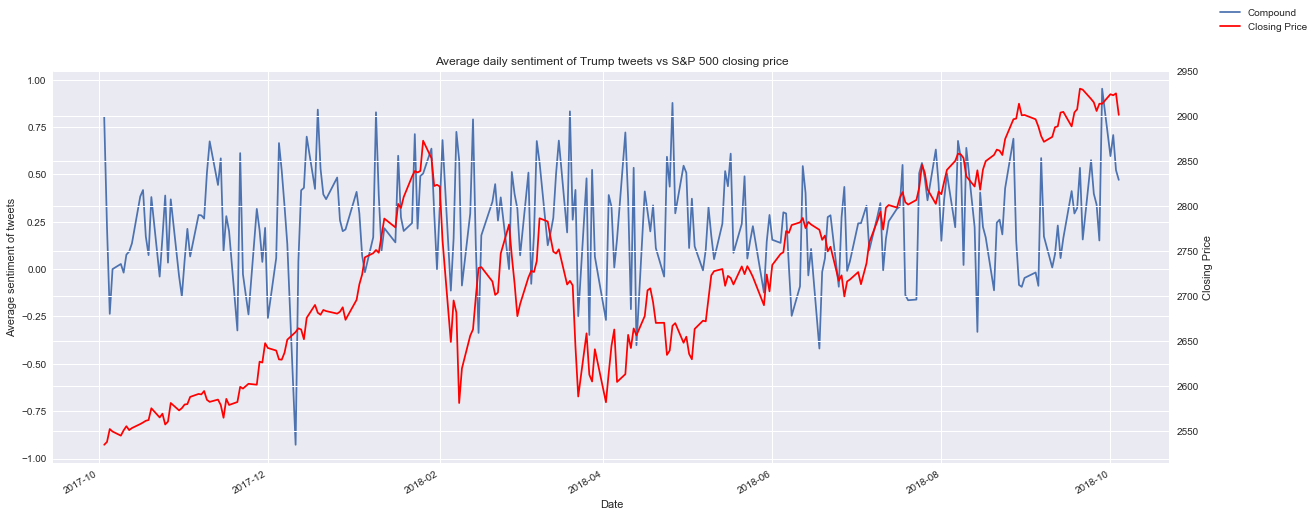

In [20]:
# plotting line chart
sns.set()
DIMS=(20, 8)

ax = twitter_df3.plot(x="Timestamp", y="Compound", figsize = DIMS, legend=False)
ax2 = ax.twinx()
twitter_df3.plot(x="Timestamp", y="Closing Price", ax=ax2, legend=False, color="r")
ax.figure.legend()
ax.set_ylabel('Average sentiment of tweets')
ax2.set_ylabel('Closing Price')
ax.set_xlabel('Date')
plt.title('Average daily sentiment of Trump tweets vs S&P 500 closing price')

plt.show()

In [97]:
# calculating change in price and sentiment
twitter_df4 = twitter_df3.copy()

twitter_df4['Change in sentiment'] = twitter_df4['Compound'].diff()
twitter_df4['Change in price'] = twitter_df4['Closing Price'].diff()
twitter_df4 = twitter_df4.dropna()
twitter_df4 = twitter_df4.reset_index(drop = True)

twitter_df4

,Timestamp,ID,Num of favourites,Num of retweets,Compound,Positive,Neutral,Negative,Closing Price,Change in sentiment,Change in price
0,2017-10-04 00:00:00-04:00,9.156174e+17,96060.000000,20385.714286,0.221486,0.248000,0.652143,0.099714,2537.739990,-0.580114,3.159912
1,2017-10-05 00:00:00-04:00,9.159333e+17,91893.333333,20165.500000,-0.236117,0.200833,0.620500,0.178667,2552.070068,-0.457602,14.330078
2,2017-10-06 00:00:00-04:00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2549.330078,0.236117,-2.739990
3,2017-10-09 00:00:00-04:00,9.174283e+17,107127.250000,21568.250000,0.027025,0.088750,0.829750,0.082000,2544.729980,0.027025,-4.600098
4,2017-10-10 00:00:00-04:00,9.177767e+17,79096.444444,17379.111111,-0.018689,0.130111,0.741889,0.128000,2550.639893,-0.045714,5.909913
5,2017-10-11 00:00:00-04:00,9.181607e+17,68130.714286,14030.785714,0.076379,0.176571,0.701929,0.121429,2555.239990,0.095067,4.600097
6,2017-10-12 00:00:00-04:00,9.185081e+17,57416.600000,12494.100000,0.092640,0.227200,0.628800,0.144100,2550.929932,0.016261,-4.310058
7,2017-10-13 00:00:00-04:00,9.189025e+17,61694.400000,13753.600000,0.135980,0.163800,0.713067,0.123067,2553.169922,0.043340,2.239990
8,2017-10-16 00:00:00-04:00,9.199304e+17,80926.571429,17586.000000,0.383514,0.215857,0.747143,0.036857,2557.639893,0.247534,4.469971
9,2017-10-17 00:00:00-04:00,9.203886e+17,53948.200000,12896.100000,0.417480,0.320100,0.627600,0.052300,2559.360107,0.033966,1.720214


In [98]:
twitter_df4.dtypes

Timestamp              datetime64[ns, US/Eastern]
ID                                        float64
Num of favourites                         float64
Num of retweets                           float64
Compound                                  float64
Positive                                  float64
Neutral                                   float64
Negative                                  float64
Closing Price                             float64
Change in sentiment                       float64
Change in price                           float64
dtype: object

In [99]:
# determining movement directions for sentiment and price
relationship = []

for i, row in twitter_df4.iterrows():
    if (row['Change in sentiment'] > 0) & (row['Change in price'] < 0):
        relationship.append('Increase in sentiment, decrease in price')
    elif (row['Change in sentiment'] < 0) & (row['Change in price'] > 0):
        relationship.append('Decrease in sentiment, increase in price')
    else:
        relationship.append('Sentiment and price move in same direction')
relationship

['Decrease in sentiment, increase in price',
 'Decrease in sentiment, increase in price',
 'Increase in sentiment, decrease in price',
 'Increase in sentiment, decrease in price',
 'Decrease in sentiment, increase in price',
 'Sentiment and price move in same direction',
 'Increase in sentiment, decrease in price',
 'Sentiment and price move in same direction',
 'Sentiment and price move in same direction',
 'Sentiment and price move in same direction',
 'Decrease in sentiment, increase in price',
 'Decrease in sentiment, increase in price',
 'Sentiment and price move in same direction',
 'Sentiment and price move in same direction',
 'Sentiment and price move in same direction',
 'Increase in sentiment, decrease in price',
 'Decrease in sentiment, increase in price',
 'Sentiment and price move in same direction',
 'Sentiment and price move in same direction',
 'Decrease in sentiment, increase in price',
 'Sentiment and price move in same direction',
 'Sentiment and price move in same 

In [100]:
twitter_df4['Relationship'] = relationship
twitter_df4

,Timestamp,ID,Num of favourites,Num of retweets,Compound,Positive,Neutral,Negative,Closing Price,Change in sentiment,Change in price,Relationship
0,2017-10-04 00:00:00-04:00,9.156174e+17,96060.000000,20385.714286,0.221486,0.248000,0.652143,0.099714,2537.739990,-0.580114,3.159912,"Decrease in sentiment, increase in price"
1,2017-10-05 00:00:00-04:00,9.159333e+17,91893.333333,20165.500000,-0.236117,0.200833,0.620500,0.178667,2552.070068,-0.457602,14.330078,"Decrease in sentiment, increase in price"
2,2017-10-06 00:00:00-04:00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2549.330078,0.236117,-2.739990,"Increase in sentiment, decrease in price"
3,2017-10-09 00:00:00-04:00,9.174283e+17,107127.250000,21568.250000,0.027025,0.088750,0.829750,0.082000,2544.729980,0.027025,-4.600098,"Increase in sentiment, decrease in price"
4,2017-10-10 00:00:00-04:00,9.177767e+17,79096.444444,17379.111111,-0.018689,0.130111,0.741889,0.128000,2550.639893,-0.045714,5.909913,"Decrease in sentiment, increase in price"
5,2017-10-11 00:00:00-04:00,9.181607e+17,68130.714286,14030.785714,0.076379,0.176571,0.701929,0.121429,2555.239990,0.095067,4.600097,Sentiment and price move in same direction
6,2017-10-12 00:00:00-04:00,9.185081e+17,57416.600000,12494.100000,0.092640,0.227200,0.628800,0.144100,2550.929932,0.016261,-4.310058,"Increase in sentiment, decrease in price"
7,2017-10-13 00:00:00-04:00,9.189025e+17,61694.400000,13753.600000,0.135980,0.163800,0.713067,0.123067,2553.169922,0.043340,2.239990,Sentiment and price move in same direction
8,2017-10-16 00:00:00-04:00,9.199304e+17,80926.571429,17586.000000,0.383514,0.215857,0.747143,0.036857,2557.639893,0.247534,4.469971,Sentiment and price move in same direction
9,2017-10-17 00:00:00-04:00,9.203886e+17,53948.200000,12896.100000,0.417480,0.320100,0.627600,0.052300,2559.360107,0.033966,1.720214,Sentiment and price move in same direction


In [101]:
# grouping data to find frequency of comovement
twitter_df4_count = twitter_df4.groupby('Relationship').size()
twitter_df4_count = twitter_df4_count.reset_index(name='Count of relationship')
twitter_df4_count['Percentage'] = twitter_df4_count['Count of relationship']/sum(twitter_df4_count['Count of relationship']) * 100
twitter_df4_count

,Relationship,Count of relationship,Percentage
0,"Decrease in sentiment, increase in price",71,28.063241
1,"Increase in sentiment, decrease in price",56,22.134387
2,Sentiment and price move in same direction,126,49.802372


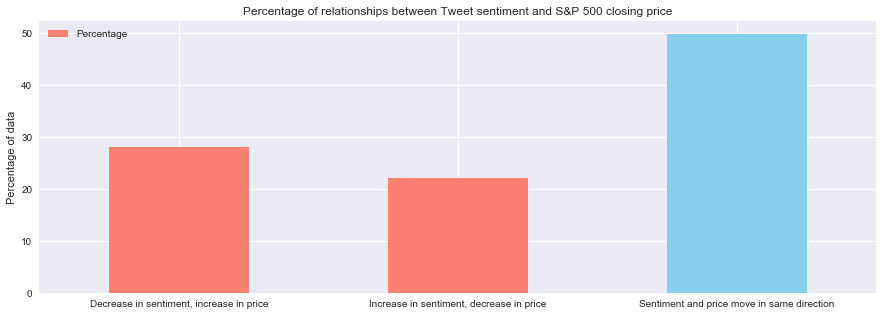

In [102]:
# plotting bar chart
twitter_df4_count.plot(kind='bar', x='Relationship', y='Percentage', figsize=(15, 5), rot= 0,
                       color= ['salmon', 'salmon', 'skyblue'],
                       title="Percentage of relationships between Tweet sentiment and S&P 500 closing price")
plt.ylabel("Percentage of data")
plt.xlabel("")
plt.show()

## Part 2: investigating comovement between previous day average sentiment of tweets and same day S&P 500 closing prices

In [103]:
# creating the first lag
twitter_df5 = twitter_df3.copy()
twitter_df5['First lag sentiment'] = twitter_df5['Compound'].shift(1)
twitter_df5 = twitter_df5.dropna()
twitter_df5

,Timestamp,ID,Num of favourites,Num of retweets,Compound,Positive,Neutral,Negative,Closing Price,First lag sentiment
1,2017-10-04 00:00:00-04:00,9.156174e+17,96060.000000,20385.714286,0.221486,0.248000,0.652143,0.099714,2537.739990,0.801600
2,2017-10-05 00:00:00-04:00,9.159333e+17,91893.333333,20165.500000,-0.236117,0.200833,0.620500,0.178667,2552.070068,0.221486
3,2017-10-06 00:00:00-04:00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2549.330078,-0.236117
4,2017-10-09 00:00:00-04:00,9.174283e+17,107127.250000,21568.250000,0.027025,0.088750,0.829750,0.082000,2544.729980,0.000000
5,2017-10-10 00:00:00-04:00,9.177767e+17,79096.444444,17379.111111,-0.018689,0.130111,0.741889,0.128000,2550.639893,0.027025
6,2017-10-11 00:00:00-04:00,9.181607e+17,68130.714286,14030.785714,0.076379,0.176571,0.701929,0.121429,2555.239990,-0.018689
7,2017-10-12 00:00:00-04:00,9.185081e+17,57416.600000,12494.100000,0.092640,0.227200,0.628800,0.144100,2550.929932,0.076379
8,2017-10-13 00:00:00-04:00,9.189025e+17,61694.400000,13753.600000,0.135980,0.163800,0.713067,0.123067,2553.169922,0.092640
9,2017-10-16 00:00:00-04:00,9.199304e+17,80926.571429,17586.000000,0.383514,0.215857,0.747143,0.036857,2557.639893,0.135980
10,2017-10-17 00:00:00-04:00,9.203886e+17,53948.200000,12896.100000,0.417480,0.320100,0.627600,0.052300,2559.360107,0.383514


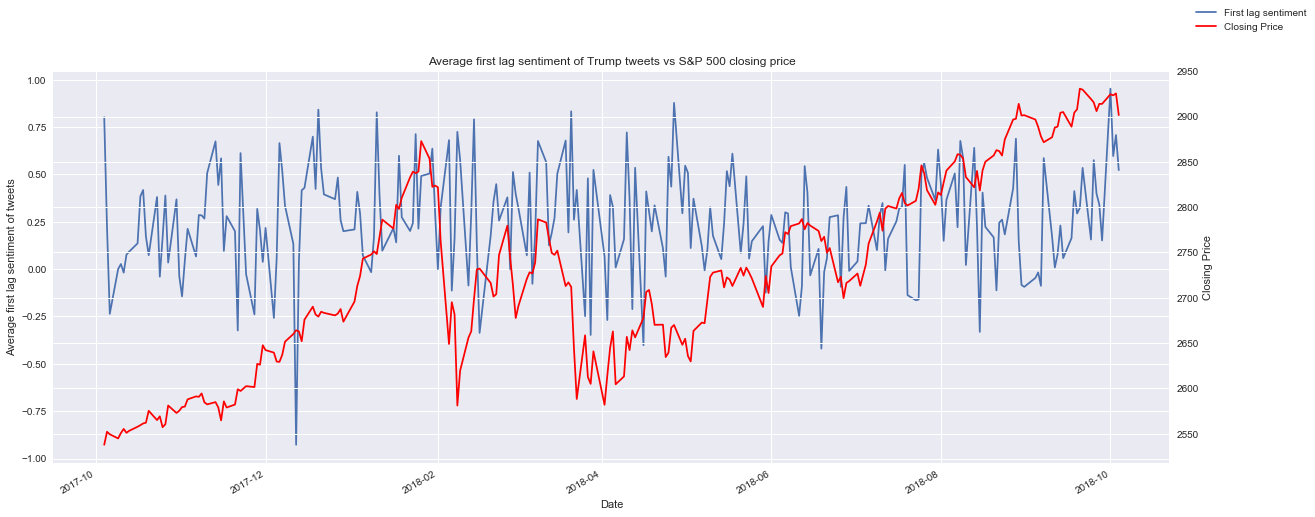

In [104]:
# plotting line graph
ax = twitter_df5.plot(x="Timestamp", y="First lag sentiment", figsize = DIMS, legend=False)
ax2 = ax.twinx()
twitter_df5.plot(x="Timestamp", y="Closing Price", ax=ax2, legend=False, color="r")
ax.figure.legend()
ax.set_ylabel('Average first lag sentiment of tweets')
ax2.set_ylabel('Closing Price')
ax.set_xlabel('Date')
plt.title('Average first lag sentiment of Trump tweets vs S&P 500 closing price')

plt.show()

In [105]:
# calculating change in price and sentiment
twitter_df6 = twitter_df5.copy()

twitter_df6['Change in sentiment'] = twitter_df6['First lag sentiment'].diff()
twitter_df6['Change in price'] = twitter_df6['Closing Price'].diff()
twitter_df6 = twitter_df6.dropna()
twitter_df6 = twitter_df6.reset_index(drop = True)

twitter_df6

,Timestamp,ID,Num of favourites,Num of retweets,Compound,Positive,Neutral,Negative,Closing Price,First lag sentiment,Change in sentiment,Change in price
0,2017-10-05 00:00:00-04:00,9.159333e+17,91893.333333,20165.500000,-0.236117,0.200833,0.620500,0.178667,2552.070068,0.221486,-0.580114,14.330078
1,2017-10-06 00:00:00-04:00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2549.330078,-0.236117,-0.457602,-2.739990
2,2017-10-09 00:00:00-04:00,9.174283e+17,107127.250000,21568.250000,0.027025,0.088750,0.829750,0.082000,2544.729980,0.000000,0.236117,-4.600098
3,2017-10-10 00:00:00-04:00,9.177767e+17,79096.444444,17379.111111,-0.018689,0.130111,0.741889,0.128000,2550.639893,0.027025,0.027025,5.909913
4,2017-10-11 00:00:00-04:00,9.181607e+17,68130.714286,14030.785714,0.076379,0.176571,0.701929,0.121429,2555.239990,-0.018689,-0.045714,4.600097
5,2017-10-12 00:00:00-04:00,9.185081e+17,57416.600000,12494.100000,0.092640,0.227200,0.628800,0.144100,2550.929932,0.076379,0.095067,-4.310058
6,2017-10-13 00:00:00-04:00,9.189025e+17,61694.400000,13753.600000,0.135980,0.163800,0.713067,0.123067,2553.169922,0.092640,0.016261,2.239990
7,2017-10-16 00:00:00-04:00,9.199304e+17,80926.571429,17586.000000,0.383514,0.215857,0.747143,0.036857,2557.639893,0.135980,0.043340,4.469971
8,2017-10-17 00:00:00-04:00,9.203886e+17,53948.200000,12896.100000,0.417480,0.320100,0.627600,0.052300,2559.360107,0.383514,0.247534,1.720214
9,2017-10-18 00:00:00-04:00,9.206893e+17,64911.000000,15604.687500,0.172569,0.150062,0.763312,0.086625,2561.260010,0.417480,0.033966,1.899903


In [110]:
# determining movement directions for sentiment and price
relationship = []

for i, row in twitter_df6.iterrows():
    if (row['Change in sentiment'] > 0) & (row['Change in price'] < 0):
        relationship.append('Increase in sentiment, decrease in price')
    elif (row['Change in sentiment'] < 0) & (row['Change in price'] > 0):
        relationship.append('Decrease in sentiment, increase in price')
    else:
        relationship.append('Sentiment and price move in same direction')

twitter_df6['Relationship'] = relationship
twitter_df6

,Timestamp,ID,Num of favourites,Num of retweets,Compound,Positive,Neutral,Negative,Closing Price,First lag sentiment,Change in sentiment,Change in price,Relationship
0,2017-10-05 00:00:00-04:00,9.159333e+17,91893.333333,20165.500000,-0.236117,0.200833,0.620500,0.178667,2552.070068,0.221486,-0.580114,14.330078,"Decrease in sentiment, increase in price"
1,2017-10-06 00:00:00-04:00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2549.330078,-0.236117,-0.457602,-2.739990,Sentiment and price move in same direction
2,2017-10-09 00:00:00-04:00,9.174283e+17,107127.250000,21568.250000,0.027025,0.088750,0.829750,0.082000,2544.729980,0.000000,0.236117,-4.600098,"Increase in sentiment, decrease in price"
3,2017-10-10 00:00:00-04:00,9.177767e+17,79096.444444,17379.111111,-0.018689,0.130111,0.741889,0.128000,2550.639893,0.027025,0.027025,5.909913,Sentiment and price move in same direction
4,2017-10-11 00:00:00-04:00,9.181607e+17,68130.714286,14030.785714,0.076379,0.176571,0.701929,0.121429,2555.239990,-0.018689,-0.045714,4.600097,"Decrease in sentiment, increase in price"
5,2017-10-12 00:00:00-04:00,9.185081e+17,57416.600000,12494.100000,0.092640,0.227200,0.628800,0.144100,2550.929932,0.076379,0.095067,-4.310058,"Increase in sentiment, decrease in price"
6,2017-10-13 00:00:00-04:00,9.189025e+17,61694.400000,13753.600000,0.135980,0.163800,0.713067,0.123067,2553.169922,0.092640,0.016261,2.239990,Sentiment and price move in same direction
7,2017-10-16 00:00:00-04:00,9.199304e+17,80926.571429,17586.000000,0.383514,0.215857,0.747143,0.036857,2557.639893,0.135980,0.043340,4.469971,Sentiment and price move in same direction
8,2017-10-17 00:00:00-04:00,9.203886e+17,53948.200000,12896.100000,0.417480,0.320100,0.627600,0.052300,2559.360107,0.383514,0.247534,1.720214,Sentiment and price move in same direction
9,2017-10-18 00:00:00-04:00,9.206893e+17,64911.000000,15604.687500,0.172569,0.150062,0.763312,0.086625,2561.260010,0.417480,0.033966,1.899903,Sentiment and price move in same direction


In [111]:
# grouping data to find frequency of comovement
twitter_df6_count = twitter_df6.groupby('Relationship').size()
twitter_df6_count = twitter_df6_count.reset_index(name='Count of relationship')
twitter_df6_count['Percentage'] = twitter_df6_count['Count of relationship']/sum(twitter_df6_count['Count of relationship']) * 100
twitter_df6_count

,Relationship,Count of relationship,Percentage
0,"Decrease in sentiment, increase in price",77,30.555556
1,"Increase in sentiment, decrease in price",63,25.000000
2,Sentiment and price move in same direction,112,44.444444


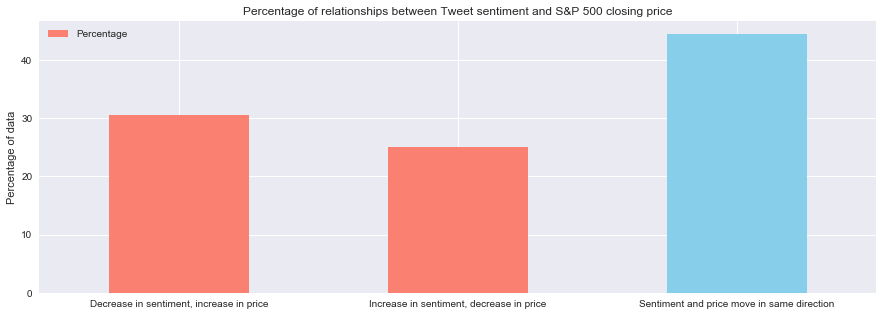

In [112]:
# plotting bar chart
twitter_df6_count.plot(kind='bar', x='Relationship', y='Percentage', figsize=(15, 5), rot= 0,
                       color= ['salmon', 'salmon', 'skyblue'],
                       title="Percentage of relationships between Tweet sentiment and S&P 500 closing price")
plt.ylabel("Percentage of data")
plt.xlabel("")
plt.show()

## Insights
**Part 1**

Daily average sentiment of tweets serves as indicator of the direction of movement of S&P 500 closing prices around 50% of the time.

**Part 2**

Previous day average sentiment of tweets serves as a leading indicator of the direction of movement of S&P 500 closing prices around 44% of the time.

**Conclusion**

The daily average sentiment of Trump's tweets can be used in conjunction with other variables to develop a trading strategy for the S&P 500.

**Future areas of research**
- Comovement of daily average sentiment of Trump's tweets with other US stock indexes such as NASDAQ Composite and Dow Jones Industrial Average